In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')
ct=0

C:\Users\sskim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data(file_path):
    print("read data")
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):

    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [3]:
dataset = read_data('WISDM_ar_v1.1_raw.txt')
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
print("dataY")
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
print("dataY")
print("dataset['z-axis']",dataset['z-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])
print("READ DATA")

read data
dataY
dataY
dataset['z-axis'] 0          0.503953
1          0.953424
2         -0.081722
3          3.023717
4          7.205164
5         -6.510526
6          5.706926
7          7.055340
8          5.134871
9          1.648062
10         2.724070
11         2.982856
12        -0.299648
13        -8.158588
14         8.539958
15         2.914754
16        -1.457377
17         9.425281
18       -10.188020
19        -9.724928
20         1.539099
21         3.718355
22         0.081722
23         6.510526
24        -4.630918
25        13.525005
26         6.170018
27         4.018002
28         2.369940
29         4.712640
            ...    
400408     0.994285
400409     1.184970
400410     0.953424
400411     0.653777
400412     0.149824
400413     0.803601
400414     0.381370
400415     0.531194
400416     0.531194
400417     0.721878
400418     0.762740
400419     1.116869
400420     1.266692
400421     1.375655
400422     1.334794
400423     1.334794
400424     1.116869


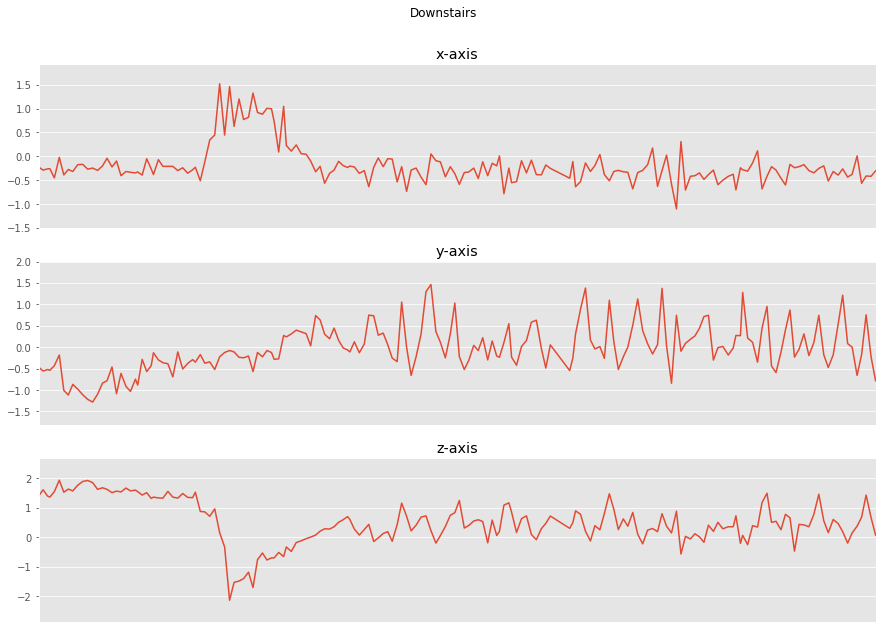

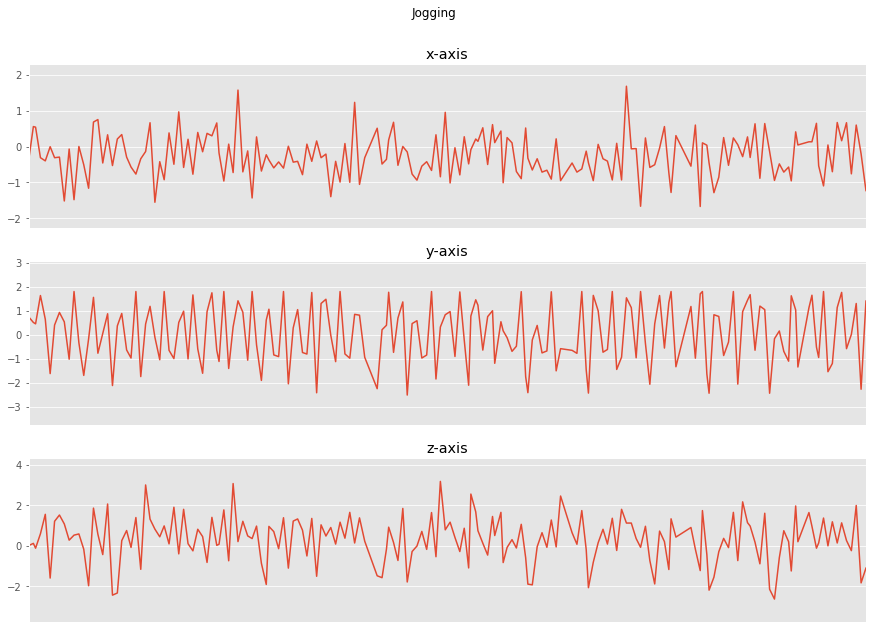

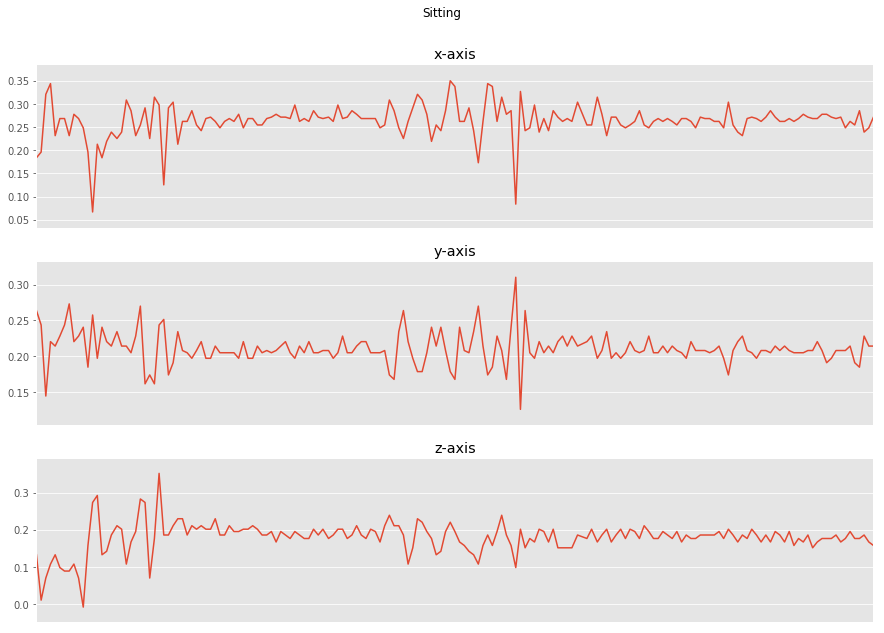

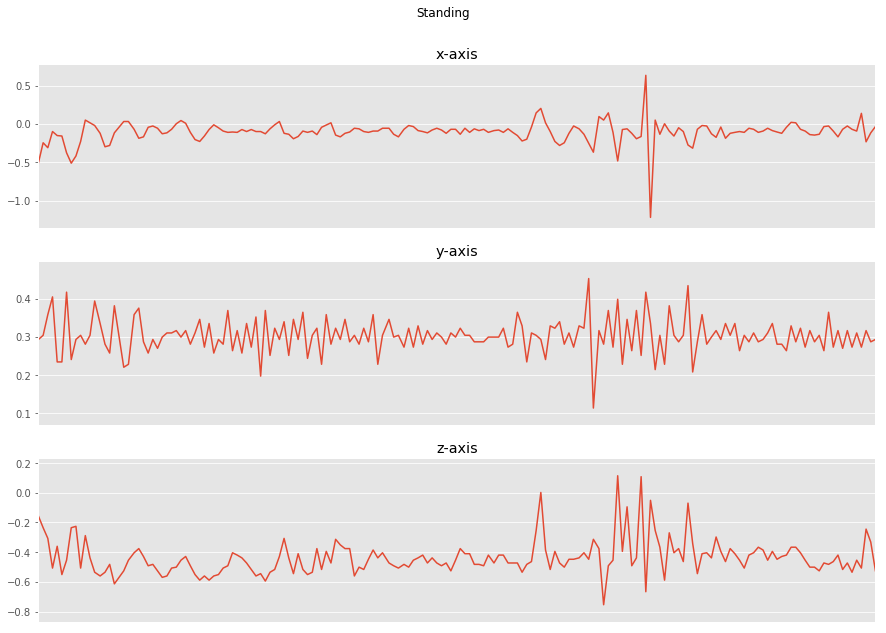

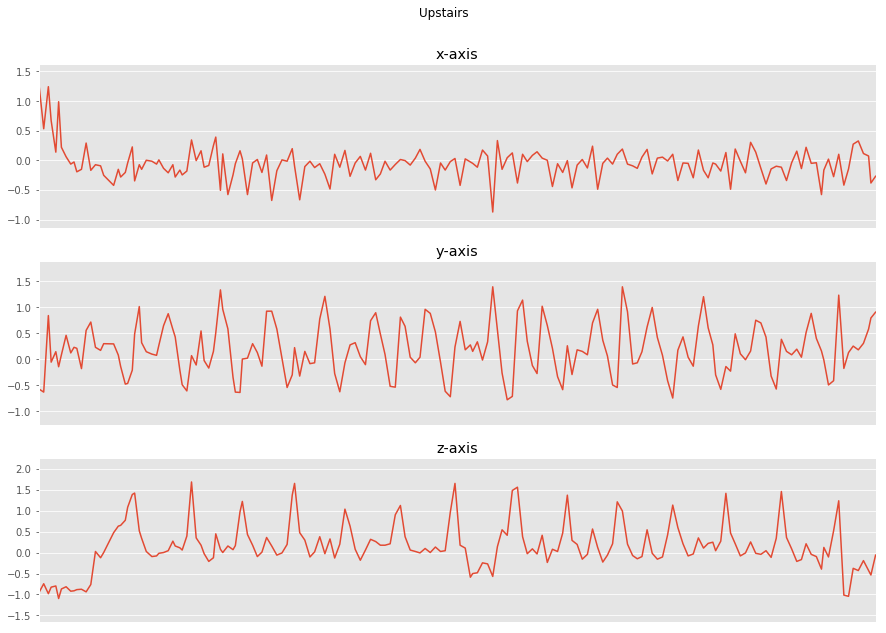

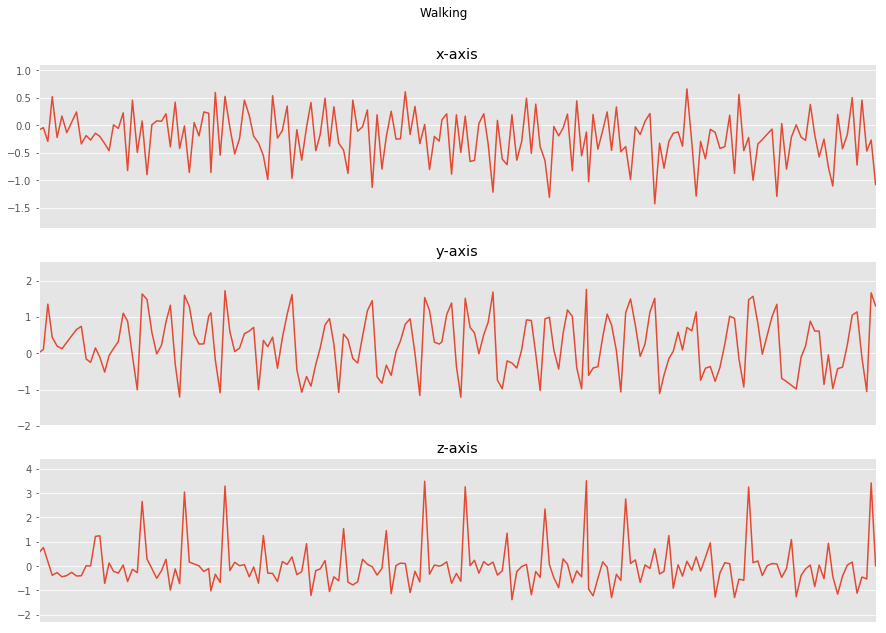

In [4]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [5]:
segments, labels = segment_signal(dataset)
print("1")
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
print("1")
reshaped_segments = segments.reshape(len(segments), 1,90, 3)
print("1")



C:\Users\sskim\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


1
1
1


In [6]:
print("RESHAPE : ",len(reshaped_segments))
print("RESHAPE : ",len(reshaped_segments[0]))
print("RESHAPE : ",len(reshaped_segments[0][0]))
print("RESHAPE : ",len(reshaped_segments[0][0][0]))


RESHAPE :  8897
RESHAPE :  1
RESHAPE :  90
RESHAPE :  3


In [7]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]
print("SPLIT")

SPLIT


In [8]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [9]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [10]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        print("1")
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

1
Epoch:  0  Training Loss:  7.394409  Training Accuracy:  0.6426282
1
Epoch:  1  Training Loss:  4.8051553  Training Accuracy:  0.71939105
1
Epoch:  2  Training Loss:  4.227813  Training Accuracy:  0.78044873
1
Epoch:  3  Training Loss:  3.902547  Training Accuracy:  0.8072115
1
Epoch:  4  Training Loss:  3.6674523  Training Accuracy:  0.825
1
Epoch:  5  Training Loss:  3.4178634  Training Accuracy:  0.8350962
1
Epoch:  6  Training Loss:  3.226838  Training Accuracy:  0.8439103
1


In [ ]:
a="a;+"
b=a.replace(";","")
print(b)